In [1]:
import requests as req
from bs4 import BeautifulSoup as bs4
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import ElementNotInteractableException
from webdriver_manager.chrome import ChromeDriverManager

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as LinReg, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from fake_useragent import UserAgent


Vamos a crear el modelo de predicción

In [5]:
df_unido = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido.csv")
df_unido2 = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido2.csv")
df_unido3 = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido3.csv")
df_final = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_final.csv")

In [6]:
df_copy = df_unido2.copy()

In [7]:
df_copy.drop(columns=['D','GF','GA'],inplace=True)
df_copy

,Equipo,GP,W,L,GD,Pts,PPG,CS,FTS
0,FC Barcelona,13,11,2,20,33,2.54,46%,0%
1,Real Madrid,12,8,2,15,26,2.17,58%,8%
2,Bayern Munich,12,8,3,20,25,2.08,50%,17%
3,Juventus,13,7,3,7,24,1.85,46%,31%
4,FC Porto,10,6,1,13,21,2.10,40%,0%
...,...,...,...,...,...,...,...,...,...
251,FC Kobenhavn,6,0,3,-11,3,0.50,33%,83%
252,Maccabi Haifa,6,1,5,-14,3,0.50,17%,17%
253,Celtic,6,0,4,-11,2,0.33,0%,33%
254,Viktoria Plzen,6,0,6,-19,0,0.00,0%,50%


In [8]:
df_copy['CS'] = pd.to_numeric(df_copy['CS'].str.rstrip('%'), errors='coerce')
df_copy['FTS'] = pd.to_numeric(df_copy['FTS'].str.rstrip('%'), errors='coerce')

In [9]:
corr=df_copy.corr(numeric_only=True)
corr

,GP,W,L,GD,Pts,PPG,CS,FTS
GP,1.000000,0.909924,-0.340718,0.770475,0.931060,0.761387,0.563144,-0.429222
W,0.909924,1.000000,-0.493951,0.881195,0.988534,0.923586,0.621625,-0.524129
L,-0.340718,-0.493951,1.000000,-0.672731,-0.576452,-0.719128,-0.476309,0.526180
GD,0.770475,0.881195,-0.672731,1.000000,0.899578,0.897375,0.629891,-0.614022
Pts,0.931060,0.988534,-0.576452,0.899578,1.000000,0.932003,0.640420,-0.546672
PPG,0.761387,0.923586,-0.719128,0.897375,0.932003,1.000000,0.656450,-0.607522
CS,0.563144,0.621625,-0.476309,0.629891,0.640420,0.656450,1.000000,-0.185358
FTS,-0.429222,-0.524129,0.526180,-0.614022,-0.546672,-0.607522,-0.185358,1.000000


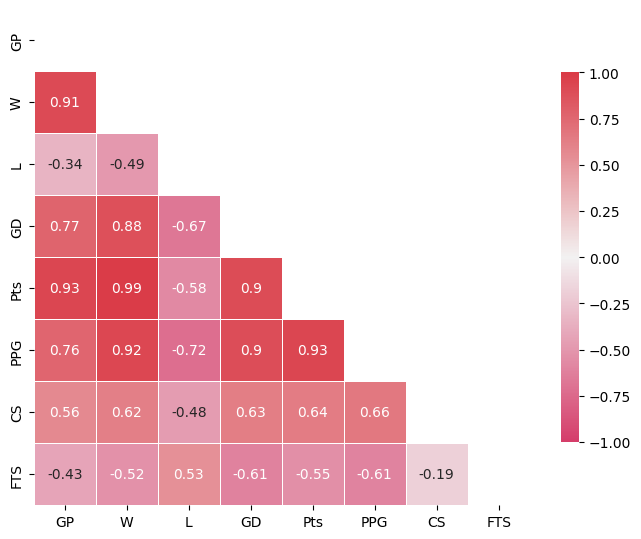

In [10]:
fig, ax=plt.subplots(figsize=(8,8))

mask=np.triu(np.ones_like(corr, dtype=bool))

color_map=sns.diverging_palette(0, 10, as_cmap=True)

# Heatmap
sns.heatmap(corr,                       # datos
            mask=mask,                  # mascara
            cmap=color_map,             # color
            vmax=1,
            vmin=-1, #QUE ALGUINE PREGUNTÓ EL OTRO DíA PERO AL FINAL NO LO CAMBIAMOS
            #center=0,                  # valor central
            square=True,
            annot=True,
            linewidth=.5,
            cbar_kws={'shrink': .6},
            ax=ax                       # eje
           );

In [11]:
#Voy a coger todas las columnas que son numéricas y estandarizarlas
data_num=pd.DataFrame(StandardScaler().fit_transform(df_copy._get_numeric_data()),
                      columns=df_copy._get_numeric_data().columns)

#Voy a coger todas columnas que son categóricas
data_obj=df_copy.select_dtypes(include='object')

#Junto todas de nuevo
data = pd.concat([data_num, data_obj], axis=1)
data.head()

,GP,W,L,GD,Pts,PPG,CS,FTS,Equipo
0,2.313603,3.064415,-0.855404,2.196423,2.791391,2.011296,1.047458,-1.478061,FC Barcelona
1,1.867607,1.905641,-0.855404,1.647317,1.908083,1.432801,1.659787,-1.098777,Real Madrid
2,1.867607,1.905641,-0.053267,2.196423,1.781897,1.292086,1.251568,-0.672082,Bayern Munich
3,2.313603,1.519383,-0.053267,0.768748,1.655710,0.932481,1.047458,-0.008334,Juventus
4,0.975616,1.133124,-1.657542,1.427675,1.277149,1.323356,0.741293,-1.478061,FC Porto


In [12]:
data

,GP,W,L,GD,Pts,PPG,CS,FTS,Equipo
0,2.313603,3.064415,-0.855404,2.196423,2.791391,2.011296,1.047458,-1.478061,FC Barcelona
1,1.867607,1.905641,-0.855404,1.647317,1.908083,1.432801,1.659787,-1.098777,Real Madrid
2,1.867607,1.905641,-0.053267,2.196423,1.781897,1.292086,1.251568,-0.672082,Bayern Munich
3,2.313603,1.519383,-0.053267,0.768748,1.655710,0.932481,1.047458,-0.008334,Juventus
4,0.975616,1.133124,-1.657542,1.427675,1.277149,1.323356,0.741293,-1.478061,FC Porto
...,...,...,...,...,...,...,...,...,...
251,-0.808367,-1.184424,-0.053267,-1.208032,-0.994214,-1.178244,0.384101,2.457015,FC Kobenhavn
252,-0.808367,-0.798166,1.551008,-1.537496,-0.994214,-1.178244,-0.432338,-0.672082,Maccabi Haifa
253,-0.808367,-1.184424,0.748871,-1.208032,-1.120401,-1.444039,-1.299805,0.086487,Celtic
254,-0.808367,-1.184424,2.353145,-2.086601,-1.372775,-1.959994,-1.299805,0.892467,Viktoria Plzen


In [38]:
#Quitamos los Churns y tb el CustomerID, que ese fijo que no influye
X = data.drop(columns = ['GP','L','Equipo'])

y = data['GP']

In [39]:
linreg = LinReg()

lasso = Lasso()

ridge = Ridge()

elastic = ElasticNet()

In [40]:
X_train, X_test, y_train, y_test = tts(X, y,
                                       random_state=42,
                                       test_size = 0.1,
                                       stratify=y)

In [41]:
linreg.fit(X_train, y_train)

LinearRegression()

In [42]:
linreg.intercept_    

0.007856451270820335

In [43]:
linreg.coef_        # betas, desde 1 a N

array([-0.42877246, -0.16659379,  2.21093524, -0.79137805,  0.03992649,
       -0.02638846])

In [136]:
df2_2024 = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df2_2024.csv")
df2_2024.head()

,Equipo,GP,W,D,L,GF,GA,GD,Pts,PPG,CS,FTS
0,Manchester City,8,8,0,0,24,9,15,24,3.00,12%,0%
1,Real Madrid,8,7,1,0,18,8,10,22,2.75,38%,0%
2,Bayern Munich,8,6,1,1,15,7,8,19,2.38,38%,25%
3,Atletico Madrid,8,5,2,1,19,8,11,17,2.13,25%,12%
4,Arsenal,8,5,1,2,17,5,12,16,2.00,50%,12%


In [132]:
df2_2024.drop(columns=['GP','D','GA','GF','Equipo','L'],inplace=True)

In [129]:
df2_2024['CS'] = pd.to_numeric(df2_2024['CS'].str.rstrip('%'), errors='coerce')
df2_2024['FTS'] = pd.to_numeric(df2_2024['FTS'].str.rstrip('%'), errors='coerce')

In [133]:
#Voy a coger todas las columnas que son numéricas y estandarizarlas
data_num2=pd.DataFrame(StandardScaler().fit_transform(df2_2024._get_numeric_data()),
                      columns=df2_2024._get_numeric_data().columns)

#Voy a coger todas columnas que son categóricas
data_obj2=df2_2024.select_dtypes(include='object')

#Junto todas de nuevo
data2 = pd.concat([data_num2, data_obj2], axis=1)
data2.head()

,W,GD,Pts,PPG,CS,FTS
0,2.517906,2.309401,2.314720,2.366999,-0.510606,-1.446067
1,2.035433,1.539601,1.989133,2.014963,0.985255,-1.446067
2,1.552960,1.231681,1.500753,1.493951,0.985255,0.098464
3,1.070487,1.693561,1.175166,1.141915,0.237324,-0.704692
4,1.070487,1.847521,1.012372,0.958857,1.675652,-0.704692


In [134]:
puntaje = linreg.predict(data2)
puntaje

array([ 1.80579368,  1.75937469,  1.30932591,  0.98932392,  0.8060451 ,
        0.85121288,  0.62946648,  0.94506258,  1.01755421,  0.7688466 ,
        0.48708968,  0.65578042,  0.55137006,  0.40663975,  0.40477981,
       -0.40291116, -0.42238933, -0.00661651, -0.4191806 , -0.80874889,
       -0.82616056, -0.76011331, -0.90268892, -0.96989104, -0.89408689,
       -0.82574254, -0.89087815, -0.81599828, -0.960832  , -1.07626962,
       -1.02453584, -1.12921569])

In [102]:
df_predict = pd.DataFrame({'Probabilidad': puntaje})

👀Una vez hecho todo el proceso del df 2024 hay que volver a abrirlo como estaba y simplemente agregrarle la columna de predict

In [103]:
df_predict.head(3)

,Probabilidad
0,1.805794
1,1.759375
2,1.309326


In [137]:
df2_2024.head(3)

,Equipo,GP,W,D,L,GF,GA,GD,Pts,PPG,CS,FTS
0,Manchester City,8,8,0,0,24,9,15,24,3.00,12%,0%
1,Real Madrid,8,7,1,0,18,8,10,22,2.75,38%,0%
2,Bayern Munich,8,6,1,1,15,7,8,19,2.38,38%,25%


In [138]:
df_ML = pd.concat([df2_2024,df_predict],axis=1).sort_values(by = 'Probabilidad',ascending=False)
df_ML.reset_index(inplace=True)
df_ML.drop(columns=['index'],inplace=True)

In [122]:
df_porcentaje = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_porcentaje.csv")
df_porcentaje.head()

,Equipos,Porcentaje
0,Real Madrid,83.93
1,Manchester City,66.07
2,Bayern Munich,62.50
3,FC Barcelona,48.21
4,Liverpool,48.21


In [165]:
df_unido = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido.csv")
df_unido.head()

,Fecha,Equipo1,Equipo2
0,8th Finals,-,-
1,17 Feb 15,Paris SG,Chelsea
2,17 Feb 15,Shakhtar,Bayern Munich
3,18 Feb 15,Basel,FC Porto
4,18 Feb 15,Schalke 04,Real Madrid
